In [261]:
%load_ext autoreload
%autoreload 2
from environments.rectangle import Rectangle
from environments.environment import RectangleEnv
from environments.optimizer import StepOptimizer
from algorithms import *
from models.agents import QLearningAgent, SarsaAgent
from models.trainer import Trainer
from generator2 import make_cases, build_envs_from_cases
from models.agents_nstep import NStepQLearningAgent, NStepSarsaAgent


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [229]:
from sanity_tests import *
# from example_generator import make_cases, build_envs_from_cases
import numpy as np

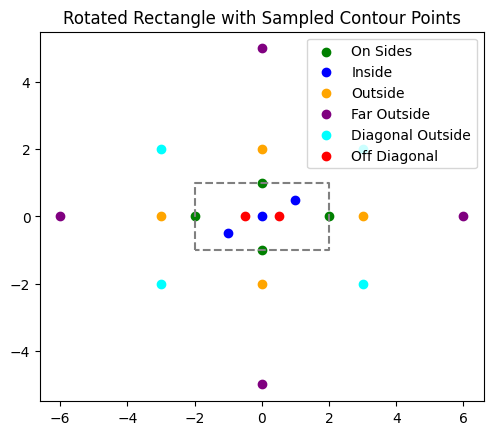

All tests passed!
Step 1: horizontal, shift=1.9999979347611103, used_iters=16
Step 2: vertical, shift=0.5000000088678954, used_iters=7


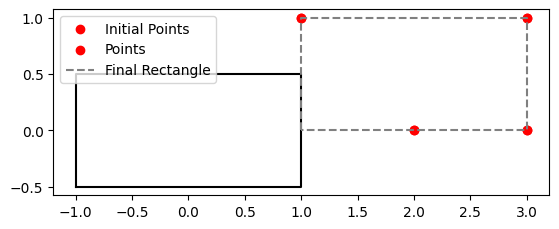


[check] encode_state invariants
Encoded state: (2, 0, 2, 0, 4, 0, 0)
 sides    (T,B,R,L):  2  0  2  0
 distances (touch,close,far):  4  0  0
  sum sides == N: True   sum bins == N: True

[check] axis isolation via apply_action()
  vertical: x unchanged? True | y changed? False
  horizontal: y unchanged? True | x changed? False

[run] short rollout using env.step()
 t        action  used   mean_before   mean_after    imprv     reward
------------------------------------------------------------------------
 0  ('horizontal', 2)     2      1.390388     0.447249   0.9431     0.5431
      expected: 0.7431  (set compute_reward(alpha=1,beta=0.1) to match)
      invariants: sides_sum==N? True | bins_sum==N? True
 1  ('vertical', 2)     2      0.447249     0.128897   0.3184     9.9184
      expected: 0.1184  (set compute_reward(alpha=1,beta=0.1) to match)
      invariants: sides_sum==N? True | bins_sum==N? True
  -> done (terminal reached by touching-all or max_steps)

[check] terminal conditi

In [208]:
if __name__ == "__main__":
    # Run the sanity checks for the Rectangle class
    test_rectangle_distance()
    # Run the sanity checks for the RectangleEnv
    sanity_check_step_optimizer()

    env = build_env()
    env.render()

    # 1) state invariants on reset
    env.reset()
    check_encode_state_invariants(env)

    # 2) axis isolation (uses apply_action only)
    check_axis_isolation(env)

    # 3) rollout that prints distances, rewards, and invariants
    rollout_and_print(env, steps=20)

    # 4) terminal checks
    check_terminal_conditions(env)

    print("\n[done] If something looks off (e.g., reward != expected), tweak compute_reward or the alpha/beta used.")

In [209]:
# rect_params = dict(center=(0, 0), width=2.0, height=1.0, theta=np.pi/6)
# optimizer_params = dict(tau=0.1, loss="soft_l1", bounds=(-5, 5))
# offsetX, offsetY = np.random.uniform(-2, 3), np.random.uniform(-2, 3)
# rect = Rectangle(**rect_params)
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots()
# rect.plot(ax=ax, color='blue', alpha=0.5)
# rect.move(dx=offsetX, dy=offsetY)
# points = rect.sample_points(num_points=10, jitter=0.0, rng=np.random.default_rng(42)) 
# ax.scatter(points[:, 0], points[:, 1], color='red', label='Sampled Points')
# env = RectangleEnv(rect_params=rect_params, optimizer_params=optimizer_params, points=points)

In [230]:
params = {
    'episodes': 500,
    'alpha': 0.1,
    'gamma': 1,
    'eps_start': 0.2,
    'eps_end': 0.01,
    'eps_decay': 0.9,
    'seed': 0
}
rect_params = dict(center=(0, 0), width=2.0, height=1.0, theta=np.pi/6)
optimizer_params = dict(tau=0.15, loss="soft_l1", bounds=(-5, 5))

# cases = make_cases(rect_params, optimizer_params, num_points=20, jitter=0.01)
# envs  = build_envs_from_cases(cases)
cases = make_cases(rect_params, optimizer_params, num_points=20, jitter_t = 0.05, jitter_n=0.01, rng=np.random.default_rng(42))
envs  = build_envs_from_cases(cases)

In [231]:
envs

{'offset_0.0_0.0_rot_0': <environment.RectangleEnv at 0x715379e6f740>,
 'offset_0.0_0.0_rot_30': <environment.RectangleEnv at 0x71537a2db0b0>,
 'offset_0.0_0.0_rot_45': <environment.RectangleEnv at 0x715379dc3560>,
 'offset_0.0_0.0_rot_-45': <environment.RectangleEnv at 0x715379951790>,
 'offset_0.0_0.0_rot_90': <environment.RectangleEnv at 0x71537a533530>,
 'offset_1.5_0.0_rot_0': <environment.RectangleEnv at 0x71537a532f30>,
 'offset_1.5_0.0_rot_30': <environment.RectangleEnv at 0x715379888bf0>,
 'offset_1.5_0.0_rot_45': <environment.RectangleEnv at 0x71537988a960>,
 'offset_1.5_0.0_rot_-45': <environment.RectangleEnv at 0x715379889730>,
 'offset_1.5_0.0_rot_90': <environment.RectangleEnv at 0x715379851100>,
 'offset_-1.2_-0.8_rot_0': <environment.RectangleEnv at 0x71537a8e8bc0>,
 'offset_-1.2_-0.8_rot_30': <environment.RectangleEnv at 0x715379127740>,
 'offset_-1.2_-0.8_rot_45': <environment.RectangleEnv at 0x7153794090a0>,
 'offset_-1.2_-0.8_rot_-45': <environment.RectangleEnv at 0

In [232]:
subset = dict(list(envs.items())[-15:-5])  
subset

{'offset_-1.2_-0.8_rot_0': <environment.RectangleEnv at 0x71537a8e8bc0>,
 'offset_-1.2_-0.8_rot_30': <environment.RectangleEnv at 0x715379127740>,
 'offset_-1.2_-0.8_rot_45': <environment.RectangleEnv at 0x7153794090a0>,
 'offset_-1.2_-0.8_rot_-45': <environment.RectangleEnv at 0x715379481340>,
 'offset_-1.2_-0.8_rot_90': <environment.RectangleEnv at 0x715379482570>,
 'offset_2.0_1.0_rot_0': <environment.RectangleEnv at 0x715379482690>,
 'offset_2.0_1.0_rot_30': <environment.RectangleEnv at 0x715379481eb0>,
 'offset_2.0_1.0_rot_45': <environment.RectangleEnv at 0x7153796c92e0>,
 'offset_2.0_1.0_rot_-45': <environment.RectangleEnv at 0x7153796c9250>,
 'offset_2.0_1.0_rot_90': <environment.RectangleEnv at 0x715379eb3c20>}

In [233]:
# q_agent = QLearningAgent(nA = 18)
# s_agent = SarsaAgent(nA = 18)
# trainer = Trainer(envs=subset, agent=s_agent)
# trainer.train(episodes=1000)

## n-step Q-learning

In [ ]:
# # q_n_agent = NStepSarsaAgent(nA = 18, n_step=3)
# q_n_agent = NStepQLearningAgent(nA = 18, n_step=1)
# trainer = Trainer(envs=subset, agent=q_n_agent)
# trainer.train(episodes=2000)
# res = []
# for name in list(envs.keys())[-5:]:
#     env = envs[name]
#     metrics = trainer.evaluation(env, episodes=5)
#     res.append((metrics))   

In [312]:
import numpy as np

res = []
for n in [1, 2, 3]:
    n_agent = NStepSarsaAgent(nA=18, n_step=n)
    trainer = Trainer(envs=subset, agent=n_agent)
    trainer.train(episodes=2000)

    all_metrics = []
    for name in list(envs.keys())[-5:]:
        metrics = trainer.evaluation(envs[name], episodes=5)  # list of dicts
        all_metrics.extend(metrics)
    res.append(all_metrics)
    print(f"Completed n-step Sarsa-learning with n={n}")


Completed n-step Sarsa-learning with n=1
Completed n-step Sarsa-learning with n=2
Completed n-step Sarsa-learning with n=3


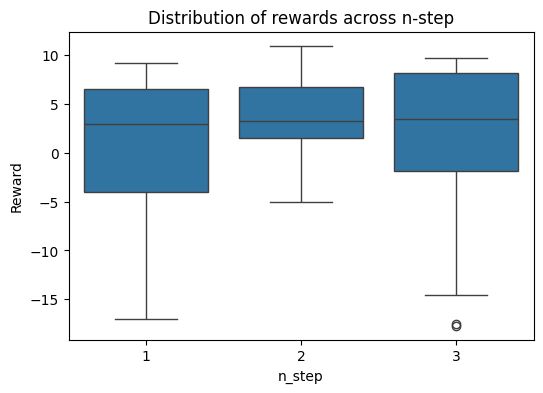

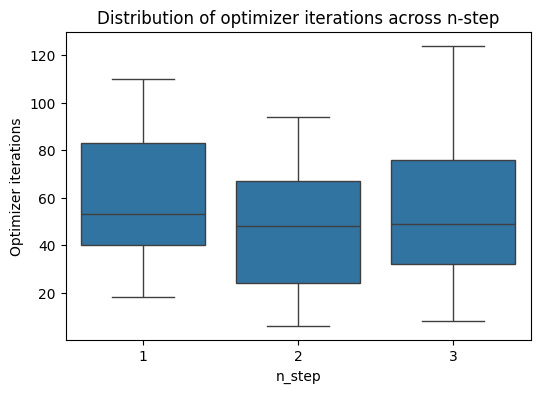

In [316]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# suppose res = [list_of_dicts_for_n1, list_for_n2, list_for_n3]
flat_res = []
for i, metrics_list in enumerate(res, start=1):   # n_step = 1,2,3
    for m in metrics_list:
        m = dict(m)  # copy to avoid inplace modification
        m["n_step"] = i
        flat_res.append(m)

df = pd.DataFrame(flat_res)

# --- Boxplot for rewards ---
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x="n_step", y="reward")
plt.title("Distribution of rewards across n-step")
plt.xlabel("n_step")
plt.ylabel("Reward")
plt.show()

# --- Boxplot for optimizer iterations ---
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x="n_step", y="optimizer_iters")
plt.title("Distribution of optimizer iterations across n-step")
plt.xlabel("n_step")
plt.ylabel("Optimizer iterations")
plt.show()


In [281]:
list(subset.keys())[-5:]

['offset_2.0_1.0_rot_0',
 'offset_2.0_1.0_rot_30',
 'offset_2.0_1.0_rot_45',
 'offset_2.0_1.0_rot_-45',
 'offset_2.0_1.0_rot_90']

In [315]:
env.show_gif()

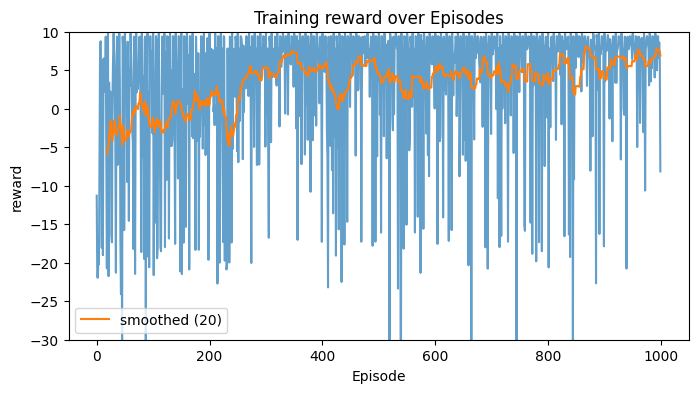

In [279]:
trainer.plot_training_logs(
    col_name="reward", smooth_window=20, ylim=(-30, 10)
)

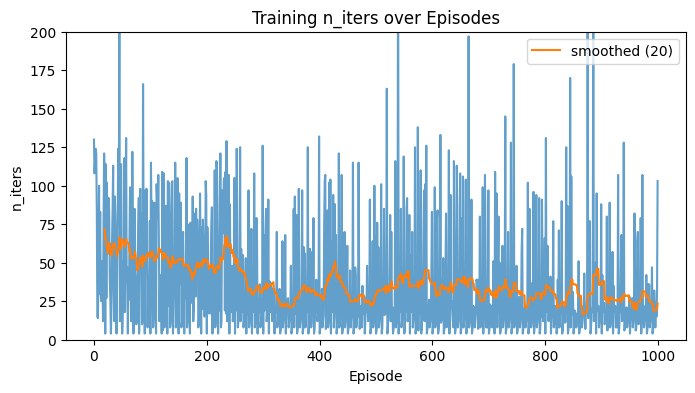

In [280]:
trainer.plot_training_logs(
    col_name="n_iters", smooth_window=20, ylim=(0, 200)
)

In [125]:
env.show_gif()